## Regularization
#### L2, L1, Dropout

##### Building Classification Model

In [6]:
import tensorflow as tf
import numpy as np


class Deep_Classifier:
    
    def __init__(self, dims=None, activations=None, lr = 0.001, lam = 0, loss='rmse', epoch = 25, batch_size = 20, \
                 print_step = 500, initial_weights = None, get_cost_step = 500, dropout_fraction = .5):
        self.dims = dims
        self.activations = activations
        self.lr = lr
        self.lam = lam
        self.loss = loss
        self.epoch = epoch
        self.batch_size = batch_size
        self.print_step = print_step
        self.depth = len(dims)
        self.get_cost_step = get_cost_step
        self.dropout_fraction = dropout_fraction
        if initial_weights==None:
            self.initial_weights = []
        else:
            if type(initial_weights) is np.ndarray:
                self.initial_weights = [initial_weights]
            else:
                self.initial_weights = initial_weights
        # weights and biases
        self.weights = []
        self.biases = []
        self.weights_l2 = []
        self.biases_l2 = []
        self.weights_l1 = []
        self.biases_l1 = []
        self.weights_dropout = []
        self.biases_dropout = []
    
    def fit(self, data, labels, validation_data, validation_labels):
            return self.run_fit(data, labels, self.dims, self.activations, self.lr, self.lam, self.loss, self.epoch, self.batch_size, self.print_step, self.get_cost_step, validation_data, validation_labels, self.dropout_fraction)
    
    
    def run_fit(self, data, labels, dims, activations, lr, lam, loss, epoch , batch_size, print_step, get_cost_step, validation_data, validation_labels, dropout_fraction):
        n_rows = data.shape[0]
        tf.reset_default_graph()
        sess = tf.Session()
        
        # tensorflow graph input
        X = tf.placeholder(tf.float32, shape = [None, data.shape[1]], name = 'X')
        y = tf.placeholder(tf.float32, shape = [None, labels.shape[1]], name = 'y')
        learning_rate = tf.placeholder(tf.float32, shape=[])
        
        weights = []
        weights_l2 = []
        weights_l1 = []
        weights_dropout = []
        biases = []
        biases_l2 = []
        biases_l1 = []
        biases_dropout = []
        activations = activations + ['softmax']
        current_dim = data.shape[1]
        output_dim = labels.shape[1]
        
        # flag for pre-train weights
        pre_train_flag = True
        
        # append Auto-Encoder Pre-Trained weights
        for idx in range(len(self.initial_weights)):
            print('Initializing with Pre-Trained Weights for Layer {}'.format(idx + 1))
            weights.append(tf.Variable(self.initial_weights[idx], dtype=tf.float32))
            weights_l2.append(tf.identity(weights[idx],))
            weights_l1.append(tf.identity(weights[idx]))
            weights_dropout.append(tf.identity(weights[idx]))
            try:
                biases.append(tf.Variable(self.initial_biases[idx], dtype=tf.float32))
                biases_l2.append(tf.identity(biases[idx]))
                biases_l1.append(tf.identity(biases[idx]))
                biases_dropout.append(tf.identity(biases[idx]))
            except:
                print('Corresponding biases not provided, initializing random biases...')
                biases.append(tf.Variable(tf.truncated_normal([dims[idx]], dtype=tf.float32)))
                biases_l2.append(tf.identity(biases[idx]))
                biases_l1.append(tf.identity(biases[idx]))
                biases_dropout.append(tf.identity(biases[idx]))
            current_dim = self.initial_weights[idx].shape[1]
        
        # append rest of the weights, the un-pretrained weights
        for idx in range(len(self.initial_weights), len(dims)):
            weights.append(tf.Variable(tf.truncated_normal([current_dim, dims[idx]], dtype=tf.float32)))
            weights_l2.append(tf.identity(weights[idx]))
            weights_l1.append(tf.identity(weights[idx]))
            weights_dropout.append(tf.identity(weights[idx]))
            biases.append(tf.Variable(tf.truncated_normal([dims[idx]], dtype=tf.float32)))
            biases_l2.append(tf.identity(biases[idx]))
            biases_l1.append(tf.identity(biases[idx]))
            biases_dropout.append(tf.identity(biases[idx]))
            current_dim = dims[idx]
        
        # append the weight for the final layer, softmax/sigmoid
        #weights.append(tf.Variable(tf.truncated_normal([current_dim, output_dim], dtype=tf.float32)))
        #biases.append(tf.Variable(tf.truncated_normal([output_dim], dtype=tf.float32)))
        weights.append(tf.Variable(tf.zeros([current_dim, output_dim], dtype=tf.float32)))
        biases.append(tf.Variable(tf.zeros([output_dim], dtype=tf.float32)))
        weights_l2.append(tf.Variable(tf.zeros([current_dim, output_dim], dtype=tf.float32)))
        biases_l2.append(tf.Variable(tf.zeros([output_dim], dtype=tf.float32)))
        weights_l1.append(tf.Variable(tf.zeros([current_dim, output_dim], dtype=tf.float32)))
        biases_l1.append(tf.Variable(tf.zeros([output_dim], dtype=tf.float32)))
        weights_dropout.append(tf.Variable(tf.zeros([current_dim, output_dim], dtype=tf.float32)))
        biases_dropout.append(tf.Variable(tf.zeros([output_dim], dtype=tf.float32)))
        
        dims=dims+[output_dim]
        
        # Regular
        output = X
        for index in range(len(dims)):
            output = self.activate(tf.matmul(output, weights[index]) + biases[index], activations[index])
        prediction = output
        
        # With L2 Weights
        output_l2 = X
        for index in range(len(dims)):
            output_l2 = self.activate(tf.matmul(output_l2, weights_l2[index]) + biases_l2[index], activations[index])
        prediction_l2 = output_l2
        
        # With L1 Weights
        output_l1 = X
        for index in range(len(dims)):
            output_l1 = self.activate(tf.matmul(output_l1, weights_l1[index]) + biases_l1[index], activations[index])
        prediction_l1 = output_l1
        
        # With Dropouts
        output_dropout = tf.nn.dropout(X, noise_shape=(1,int(X.get_shape()[1])), keep_prob = dropout_fraction)
        for index in range(len(dims)):
            if index != len(dims)-1:
                output_dropout = tf.nn.dropout(output_dropout, noise_shape=(1, int(output_dropout.get_shape()[1])), keep_prob = 1-dropout_fraction) * (1/(1-dropout_fraction))
            output_dropout = self.activate(tf.matmul(output_dropout, weights_dropout[index]) + biases_dropout[index], activations[index])
        prediction_dropout = output_dropout
        
        # Defining loss function
        if loss == 'rmse':
            cost = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y, prediction))))
            cost_l2 = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y, prediction_l2))))
            cost_l1 = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y, prediction_l1))))
            cost_dropout = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y, prediction_dropout))))
        elif loss == 'cross-entropy':
            #cost = -tf.reduce_mean(y * tf.log(prediction))
            cost=-tf.reduce_sum(y*tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
            cost_l2=-tf.reduce_sum(y*tf.log(tf.clip_by_value(prediction_l2,1e-10,1.0)))
            cost_l1=-tf.reduce_sum(y*tf.log(tf.clip_by_value(prediction_l1,1e-10,1.0)))
            cost_dropout=-tf.reduce_sum(y*tf.log(tf.clip_by_value(prediction_dropout,1e-10,1.0)))
        
        
        ## L2 Regularization ##
        for w, b in zip(weights_l2, biases_l2):
            cost_l2 += lam*tf.nn.l2_loss(w) #+ lam*tf.nn.l2_loss(b)
        
        ## L1 Regularization ##
        for w, b in zip(weights_l1, biases_l1):
            cost_l1 += lam*tf.reduce_sum(tf.abs(w)) #+ lam*tf.reduce_sum(tf.abs(b))
        
        ## Defining Training steps
        train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
        train_step_l2 = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_l2)
        train_step_l1 = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_l1)
        train_step_dropout = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_dropout)
        
        # initialize
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # Creating lists to store costs at desired steps
        cost_list = []
        cost_l2_list = []
        cost_l1_list = []
        cost_dropout_list = []
        # Creating lists to store validation costs at desired steps
        cost_validation_list = []
        cost_l2_validation_list = []
        cost_l1_validation_list = []
        cost_dropout_validation_list = []
        
        # Flag to change learning rate when true
        lr_adapt_flag = True
        
        for i in range(epoch):
            # adaptive learning rate
            if i > epoch*3/4 and lr_adapt_flag:
                print('lr prev',lr)
                lr=lr/2.
                lr_adapt_flag=False
                print('lr new',lr)    
            
            
            batch_idx = np.random.randint(data.shape[0], size = batch_size)
            batch = data[batch_idx,:]
            batch_labels = np.array(labels)[batch_idx]
                        
            sess.run(train_step, feed_dict = {X:np.array(batch), y:np.array(batch_labels), learning_rate:lr})
            sess.run(train_step_l2, feed_dict = {X:np.array(batch), y:np.array(batch_labels), learning_rate:lr})
            sess.run(train_step_l1, feed_dict = {X:np.array(batch), y:np.array(batch_labels), learning_rate:lr})
            sess.run(train_step_dropout, feed_dict = {X:np.array(batch), y:np.array(batch_labels), learning_rate:lr})
            ## For max norm
            #for idx, w in enumerate(weights_dropout):
            #    weights_dropout[idx] = tf.clip_by_norm(w, clip_norm = 1.5, axes = 0)
            
            if i % print_step == 0:
                print (i, " cost", sess.run(cost, feed_dict={X:np.array(batch), y:np.array(batch_labels)}) ,\
                       " L2 cost", sess.run(cost_l2, feed_dict={X:np.array(batch), y:np.array(batch_labels)}), \
                       " L1 cost", sess.run(cost_l1, feed_dict={X:np.array(batch), y:np.array(batch_labels)}), \
                       " Dropout cost", sess.run(cost_dropout, feed_dict={X:np.array(batch), y:np.array(batch_labels)}))
                    
            # Collect RMS Loss over Training and Validation data sets
            if i % get_cost_step == 0:
                # Appending Training Costs
                cost_list.append(sess.run(cost, feed_dict={X:np.array(data), y:np.array(labels)}))
                cost_l2_list.append(sess.run(cost_l2, feed_dict={X:np.array(data), y:np.array(labels)}))
                cost_l1_list.append(sess.run(cost_l1, feed_dict={X:np.array(data), y:np.array(labels)}))
                cost_dropout_list.append(sess.run(cost_dropout, feed_dict={X:np.array(data), y:np.array(labels)}))
                # Appending Validation Costs
                cost_validation_list.append(sess.run(cost, feed_dict={X:np.array(validation_data), y:np.array(validation_labels)}))
                cost_l2_validation_list.append(sess.run(cost_l2, feed_dict={X:np.array(validation_data), y:np.array(validation_labels)}))
                cost_l1_validation_list.append(sess.run(cost_l1, feed_dict={X:np.array(validation_data), y:np.array(validation_labels)}))
                cost_dropout_validation_list.append(sess.run(cost_dropout, feed_dict={X:np.array(validation_data), y:np.array(validation_labels)}))
                
            
        # Appending to class object
        self.cost_list = cost_list
        self.cost_l2_list = cost_l2_list
        self.cost_l1_list = cost_l1_list
        self.cost_dropout_list = cost_dropout_list
        # Over Validation Data
        self.cost_validation_list = cost_validation_list
        self.cost_l2_validation_list = cost_l2_validation_list
        self.cost_l1_validation_list = cost_l1_validation_list
        self.cost_dropout_validation_list = cost_dropout_validation_list
        
        for w, b in zip(weights, biases):
            weight = w.eval(session=sess)
            bias = b.eval(session=sess)
            self.weights.append(weight)
            self.biases.append(bias)
            
        # L2 weights and biases
        for w, b in zip(weights_l2, biases_l2):
            weight_l2 = w.eval(session=sess)
            bias_l2 = b.eval(session=sess)
            self.weights_l2.append(weight_l2)
            self.biases_l2.append(bias_l2)
            
        # L2 weights and biases
        for w, b in zip(weights_l1, biases_l1):
            weight_l1 = w.eval(session=sess)
            bias_l1 = b.eval(session=sess)
            self.weights_l1.append(weight_l1)
            self.biases_l1.append(bias_l1)
            
        # Dropout weights and biases
        for w, b in zip(weights_dropout, biases_dropout):
            weight_dropout = w.eval(session=sess)
            bias_dropout = b.eval(session=sess)
            self.weights_dropout.append(weight_dropout)
            self.biases_dropout.append(bias_dropout)
    
    
    def transform(self, data):
        tf.reset_default_graph()
        sess = tf.Session()
        X = tf.constant(data, dtype=tf.float32)
        for w, b, a in zip(self.weights, self.biases, self.activations+['softmax']):
            weight = tf.constant(w, dtype=tf.float32)
            bias = tf.constant(b, dtype=tf.float32)
            score = tf.matmul(X, weight) + b
            X = self.activate(score, a)
        ##    
        X_l2 = tf.constant(data, dtype=tf.float32)
        for w, b, a in zip(self.weights_l2, self.biases_l2, self.activations+['softmax']):
            weight = tf.constant(w, dtype=tf.float32)
            bias = tf.constant(b, dtype=tf.float32)
            score = tf.matmul(X_l2, weight) + b
            X_l2 = self.activate(score, a)
        ##
        X_l1 = tf.constant(data, dtype=tf.float32)
        for w, b, a in zip(self.weights_l1, self.biases_l1, self.activations+['softmax']):
            weight = tf.constant(w, dtype=tf.float32)
            bias = tf.constant(b, dtype=tf.float32)
            score = tf.matmul(X_l1, weight) + b
            X_l1 = self.activate(score, a)
        ##
        X_dropout = tf.constant(data, dtype=tf.float32)
        for w, b, a in zip(self.weights_dropout, self.biases_dropout, self.activations+['softmax']):
            weight = tf.constant(w, dtype=tf.float32)
            bias = tf.constant(b, dtype=tf.float32)
            score = tf.matmul(X_dropout, weight) + b
            X_dropout = self.activate(score, a)
        ##
        return {'X':X.eval(session=sess), 'X_l2':X_l2.eval(session=sess), 'X_l1':X_l1.eval(session=sess), 'X_dropout':X_dropout.eval(session=sess)}
    
    
    def activate(self, linear, name):
        if name == 'sigmoid':
            return tf.nn.sigmoid(linear, name='encoded')
        elif name == 'softmax':
            return tf.nn.softmax(linear, name='encoded')
        elif name == 'linear':
            return linear
        elif name == 'tanh':
            return tf.nn.tanh(linear, name='encoded')
        elif name == 'relu':
            return tf.nn.relu(linear, name='encoded')

##### Loading MNIST Data

In [2]:
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np

train = pd.read_csv('../data/mnist/train.csv')
y_train = train.iloc[:,0]
train = train.iloc[:,1:]

train, validation, y_train, y_validation = train_test_split(train, y_train, test_size = .2)

y_train_mat = pd.get_dummies(np.array(y_train)).as_matrix()
y_validation_mat = pd.get_dummies(np.array(y_validation)).as_matrix() 

In [3]:
from sklearn.preprocessing import Normalizer

normalize = Normalizer()
train = normalize.fit_transform(train)
validation = normalize.fit_transform(validation)

C:\Users\Neehar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Neehar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


In [7]:
mnist_dc_PT = Deep_Classifier(dims=[500], activations=['sigmoid'], lr = 0.001, lam = 0.007, loss='cross-entropy', epoch = 5000,\
                batch_size = 100, print_step = 2000, dropout_fraction = 0.3)

mnist_dc_PT.fit(data = train, labels = y_train_mat, validation_data = validation, validation_labels = y_validation_mat)

0  cost 226.174  L2 cost 1288.84  L1 cost 2210.04  Dropout cost 227.668
2000  cost 34.0612  L2 cost 48.0996  L1 cost 120.056  Dropout cost 70.3023
lr prev 0.001
lr new 0.0005
4000  cost 36.9888  L2 cost 49.5315  L1 cost 95.9824  Dropout cost 87.196


In [8]:
y_train_hat_pt = mnist_dc_PT.transform(train)
y_validation_hat_pt = mnist_dc_PT.transform(validation)
print((np.argmax(y_train_hat_pt['X'], axis=1) ==y_train).sum()/float(y_train.shape[0]), 'without Regularization')
print((np.argmax(y_validation_hat_pt['X'], axis=1) ==y_validation).sum()/float(y_validation.shape[0]), 'without Regularization')
print((np.argmax(y_train_hat_pt['X_l2'], axis=1) ==y_train).sum()/float(y_train.shape[0]), 'with l2')
print((np.argmax(y_validation_hat_pt['X_l2'], axis=1) ==y_validation).sum()/float(y_validation.shape[0]), 'with l2')
print((np.argmax(y_train_hat_pt['X_l1'], axis=1) ==y_train).sum()/float(y_train.shape[0]), 'with l1')
print((np.argmax(y_validation_hat_pt['X_l1'], axis=1) ==y_validation).sum()/float(y_validation.shape[0]), 'with l1')
print((np.argmax(y_train_hat_pt['X_dropout'], axis=1) ==y_train).sum()/float(y_train.shape[0]), 'with dropout')
print((np.argmax(y_validation_hat_pt['X_dropout'], axis=1) ==y_validation).sum()/float(y_validation.shape[0]), 'with dropout')

0.909821428571 without Regularization
0.908452380952 without Regularization
0.909880952381 with l2
0.908571428571 with l2
0.910089285714 with l1
0.909047619048 with l1
0.871875 with dropout
0.876666666667 with dropout


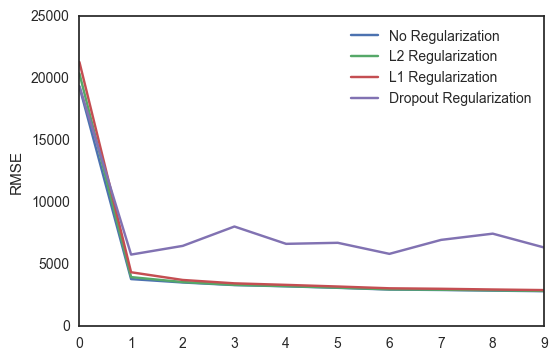

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("white")
plt.plot(mnist_dc_PT.cost_validation_list,label='No Regularization')
plt.plot(mnist_dc_PT.cost_l2_validation_list,label='L2 Regularization')
plt.plot(mnist_dc_PT.cost_l1_validation_list,label='L1 Regularization')
plt.plot(mnist_dc_PT.cost_dropout_validation_list,label='Dropout Regularization')
plt.ylabel('RMSE')
legend = plt.legend()
frame = legend.get_frame()
plt.show()

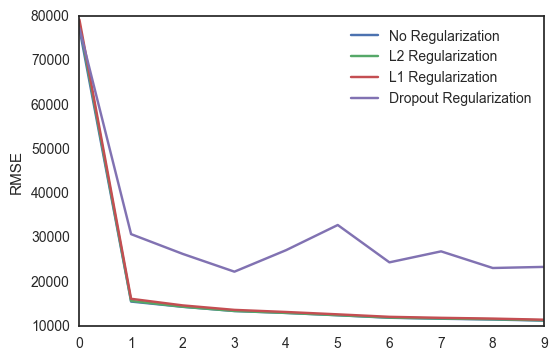

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("white")
plt.plot(mnist_dc_PT.cost_list,label='No Regularization')
plt.plot(mnist_dc_PT.cost_l2_list,label='L2 Regularization')
plt.plot(mnist_dc_PT.cost_l1_list,label='L1 Regularization')
plt.plot(mnist_dc_PT.cost_dropout_list,label='Dropout Regularization')
plt.ylabel('RMSE')
legend = plt.legend()
frame = legend.get_frame()
plt.show()